In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import math

import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

Using TensorFlow backend.


In [2]:
df = pd.read_csv("Churn_Modelling.csv")

# Pre-processing

In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


As it can be seen, the variables <b>"RowNumber", "CustomerId", and "Surname"</b> are not useful for the model. <br>
The values of these variables are unique for each observation.

In [4]:
X = df.iloc[:, 3:13]
y = df.iloc[:, 13]

### Creating dummy variables
Machine learning models cannot process words, for this reason, columns that show categories need to be converted into dummy variables. <br>
For example, the variable <b>"Gender"</b> will be transformed into a dummy variable with 0 being a female and 1 being a male. However, variables that <br>
include more than two categories, will be split into more columns. <br>
For instance, the <b>"Geography"</b> category has three levels, namely Germany, Spain, and France. This variable needs to be transformed into two binary columns. <br>
In general, the number of columns/variables that will be created from a categorical variable are <b>c-1</b>, where c is the number of levels.

In [5]:
cat = [1,2]
cat_cols = pd.get_dummies(X.iloc[:, cat], drop_first=True)

In [6]:
cat_cols.head()

,Geography_Germany,Geography_Spain,Gender_Male
0,0,0,0
1,0,1,0
2,0,0,0
3,0,0,0
4,0,1,0


In [7]:
X.drop(X.columns[cat], axis=1, inplace=True)

In [8]:
X = pd.concat([X,cat_cols], axis=1)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

Standardize the variables for the Neural Network

In [10]:
sc = StandardScaler()
X_train = pd.DataFrame(sc.fit_transform(X_train),columns = X_train.columns)
X_test = pd.DataFrame(sc.transform(X_test),columns = X_test.columns)

Now, in an Artificial Neural Network, there is an input layer, some hidden layers and an output layer. <br>
The input layer corresponds to a row/observation that travels through the neural network and outputs a specific value. <br>
So, in the image below,
<b>X1, X2, and X3,</b> are the independent variables for one row. In addition, <b>W1, W1, and W3,</b> are the weights for each variable. Note that this image does not depict the current Neural Network that we are using for this problem, but it rather shows a Neural Network with a dataset of 3 independent variables and a dependent variable.

<img src="simple_ann.png" alt="Drawing" style="width: 500px;" />

The neuron in the middle, applies an activation function based on the signals it receives. There are different activation functions, but one of the most common activation functions for the hidden layers is the Rectified Linear Unit (ReLU).
\begin{align}
f (x) = max(x,0)
\end{align} <br>
What the ReLU does, is that it returns x, if the $\sum_{i=1}^{n} W_{i}X_{i}$ is above zero and 0 otherwise, where $x = \sum_{i=1}^{n} W_{i}X_{i}$

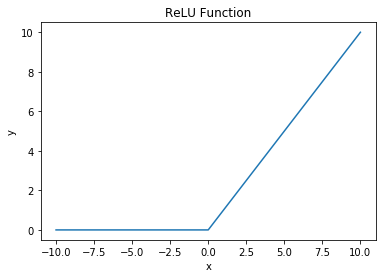

In [11]:
# rectified linear function
def rectified(x):
    return max(0.0, x)
 
# define a series of inputs
series_in = [x for x in range(-10, 11)]
# calculate outputs for our inputs
series_out = [rectified(x) for x in series_in]
# line plot of raw inputs to rectified outputs
pyplot.plot(series_in, series_out)
pyplot.xlabel('x')
pyplot.ylabel('y')
pyplot.title('ReLU Function')
pyplot.show()

The Neural Network above includes only an input layer and an output layer. For a binary classification problem such as this one, where the customer will either churn or not, the sigmoid activation function for the output layer is a more proper function. <br>

\begin{align}
f(x) = \frac{1}{1 + e^{-x}}
\end{align}

The Sigmoid function returns values ranging from 0 to 1, which is useful because in this situation, the dependent variable is either 0 (not churn) or 1 (churn). <br>
Later, by applying a threshold (e.g., 0.5), we can assign values above this threshold as 1 and below as 0.

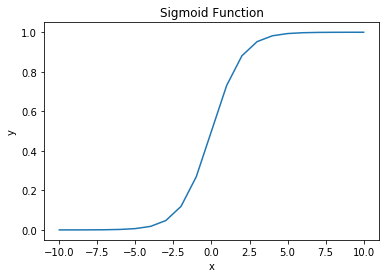

In [12]:
def sigmoid(x):
    return (1/(1 + math.exp(-x)))


# define a series of inputs
series_in = [x for x in range(-10, 11)]
# calculate outputs for our inputs
series_out = [sigmoid(x) for x in series_in]
# line plot of raw inputs to sigmoid outputs
pyplot.plot(series_in, series_out)
pyplot.xlabel('x')
pyplot.ylabel('y')
pyplot.title('Sigmoid Function')
pyplot.show()

The Neural Network below, includes an input layer with 3 neurons, a hidden layer with 4 neurons, and an output layer. <br>
In this example, the activation function of the hidden layer can be the ReLU function whereas for the output layer, it can be the sigmoid function.

<img src="tikz10.png" alt="Drawing" style="width: 500px;" />

### Neural Network

The ANN is build using the Keras framework, which uses TensorFlow in the backend. <br>
In the code below, the number of nodes in the input layers needs to be defined. This is the <b>"input_dim"</b> argument, which corresponds to the number of independent variables. Next, the <b>"units"</b> argument, defines the number of neurons in the hidden layer. Note that the architecture below shows a Neural Network with two hidden layers. The input layer and the first hidden layer are both defined in one line of code, while the rest of the layers are defined later. <br>
This means that the hidden layers have 6 neurons each with a <i>ReLU</i> activation function as described above while the output layer has 1 neuron and a <i>sigmoid</i> activation function as this is a binary classification problem. <br>
<br>
Next, the ANN model is compiled where the <b>optimizer</b>, the <b>loss</b>, and the <b>metric</b> is being defined. The optimizer argument defines the optimizer that will be used in order to update the weights of the model. Amongst those are the <i>Stochastic Gradient Descent</i>, the <i>Adaptive Moment Estimation (Adam)</i>, and the <i>Root Mean Squared Propagetion (RMSProp)</i>. The most popular optimizers are the Adam and the RMSProp. <br>
For this problem, the <i>binary cross entropy (logarithmic)</i> loss is used.

\begin{align}
\small
Logarithmic Loss = - \frac{1}{n} \; \sum_{i=1}^{n} \bigg(y^{i} \; log\phi \bigg( \sum_{j=1}{m}w_{j}x_{j}^{i} \bigg) + (1-y^{i})log \bigg(1 - \phi \bigg(\sum_{j=1}^{m}w_{j}x_{j}^{i} \bigg) \bigg) \bigg)
\end{align}

where $\phi$ is the sigmoid function, i is the index of the observation and j is the index of the feature. <br>
<br>
The metric, is the metric that will be shown, and in this case it is the accuracy.

### Model Architecture

In [13]:
classifier = Sequential()

classifier.add(Dense(units=6, activation='relu',input_dim=11))
classifier.add(Dense(units=6, activation='relu'))
classifier.add(Dense(units=1, activation='sigmoid'))
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


Instructions for updating:
Colocations handled automatically by placer.


The architecture of the current ANN is shown below.

In [14]:
print(classifier.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________
None


After defining the model architecture, in order to train the model to the training data, the batch size as well as the number of epochs need to be defined. <br>
The batch size essentially shows after how many observations the weights will be updated. For instance, with a batch size of 32, 32 observations will pass through the ANN and after that, the weights will be updated. <br>
<br>
Next, the number of epochs shows how many times all the observations will pass through the neural network.

In [15]:
classifier.fit(X_train, y_train, batch_size=32, epochs=50)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
8000/8000 [==============================] - 4s 477us/step - loss: 0.5187 - acc: 0.7902
Epoch 2/50
8000/8000 [==============================] - 1s 132us/step - loss: 0.4584 - acc: 0.7945
Epoch 3/50
8000/8000 [==============================] - 1s 137us/step - loss: 0.4435 - acc: 0.7945
Epoch 4/50
8000/8000 [==============================] - 1s 128us/step - loss: 0.4356 - acc: 0.7943
Epoch 5/50
8000/8000 [==============================] - 1s 119us/step - loss: 0.4285 - acc: 0.8103
Epoch 6/50
8000/8000 [==============================] - 1s 117us/step - loss: 0.4218 - acc: 0.8197
Epoch 7/50
8000/8000 [==============================] - 1s 121us/step - loss: 0.4162 - acc: 0.8216
Epoch 8/50
8000/8000 [==============================] - 1s 121us/step - loss: 0.4115 - acc: 0.8233
Epoch 9/50
8000/8000 [==============================] - 1s 117us/step - loss: 0.4076 - acc: 0.8239
Epoch 10/50
8000/8000 [==============================] - 1s 1

Furthermore, as explained previously, the model will make predictions on the test set, and a threshold will be set in order to classify the customers that are going to churn and those that are not. <br>
The threshold that is applied here is 0.5.

In [16]:
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)

Finally, with a <b>confusion matrix</b>, we can see how many observations were correctly predicted. More specifically, a confusion matrix gives information about the <b>True Positive rate, True Negative rate, False Positive rate, and False Negative rate</b>. It is also useful in cases when the dataset is severely unbalanced. In these cases, the confusion matrix shows if the model predicts every observation into one class. The accuracy values in these unbalanced datasets can be misleading, as it can be very high. <br>
<br>
For this particular problem, the dataset is balanced.

In [17]:
labels = [0, 1]
cm = confusion_matrix(y_test, y_pred, labels)
print(cm)
print('Accuracy: ',(cm[0,0]+cm[1,1])/len(y_test)*100)

[[1528   79]
 [ 206  187]]
Accuracy:  85.75


For this classification problem regarding customer churn, the model correctly predicted that 1528 customers will not churn and 187 customers will churn. In addition, it falsely predicted that 79 customers will churn and that 206 will not churn. The <b>accuracy</b> of the model is <b>85.75%</b>. Below, a plot of the confusion matrix is shown.

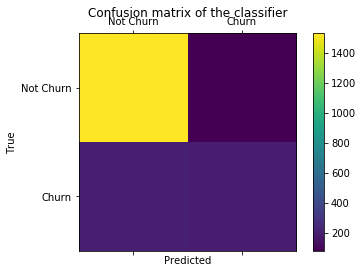

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + ['Not Churn', 'Churn'])
ax.set_yticklabels([''] + ['Not Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()